# **0 - Import Library**

In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from scipy.stats import chi2
from scipy import stats

# **1 - Import Data**

In [51]:
# Dictionary untuk menyimpan data harga 'Close'
close_data = {}

# Mengambil data saham BBRI.JK
stock_data = yf.download('BBRI.JK', start="2024-06-01", end="2024-12-01")
close_data['BBRI.JK'] = stock_data['Close']  # Simpan kolom 'Close' saja dengan simbol saham sebagai kunci

# Menggabungkan data 'Close' menjadi satu DataFrame
data = pd.DataFrame(close_data)

# Menampilkan data
data

[*********************100%***********************]  1 of 1 completed


,BBRI.JK
Date,
2024-06-03,4530.0
2024-06-04,4450.0
2024-06-05,4400.0
2024-06-06,4500.0
2024-06-07,4350.0
...,...
2024-11-22,4400.0
2024-11-25,4470.0
2024-11-26,4400.0


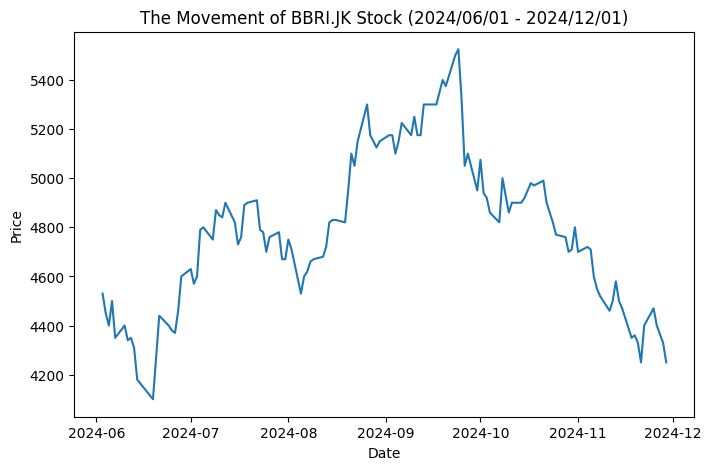

In [52]:
# Plot harga penutupan saham BBRI.JK
plt.figure(figsize=(8, 5))
plt.plot(data.index, data['BBRI.JK'], label='BBRI.JK')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('The Movement of BBRI.JK Stock (2024/06/01 - 2024/12/01)')
plt.show()

In [53]:
#Menghitung log return saham
log_ret = np.log(data/data.shift(1))
log_ret.head()

,BBRI.JK
Date,
2024-06-03,NaN
2024-06-04,-0.017818
2024-06-05,-0.011300
2024-06-06,0.022473
2024-06-07,-0.033902


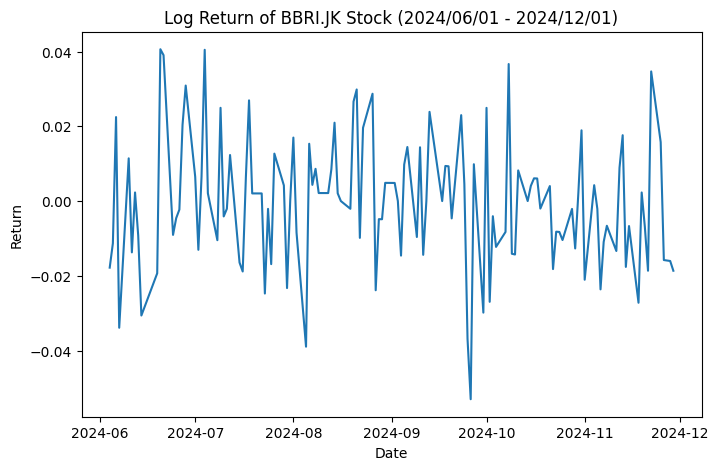

In [54]:
# Plot log return
plt.figure(figsize=(8, 5))
plt.plot(log_ret.index, log_ret['BBRI.JK'], label='BBRI.JK')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Log Return of BBRI.JK Stock (2024/06/01 - 2024/12/01)')
plt.show()

In [55]:
log_ret.describe()

,BBRI.JK
count,125.000000
mean,-0.000510
std,0.017562
min,-0.053024
25%,-0.012685
50%,0.000000
75%,0.009302
max,0.040627


# **2 - Uji Asumsi**

## Uji Stasioneritas

In [56]:
# Uji ADF
adf_test = adfuller(log_ret['BBRI.JK'][1:])

# Hasil
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -11.055980007147115
p-value: 4.943812061470985e-20
Critical Values:
   1%: -3.484219653271961
   5%: -2.885145235641637
   10%: -2.579359138917794


## Uji Normalitas

In [57]:
# Uji Jarque-Bera
stat, p_value = jarque_bera(log_ret['BBRI.JK'][1:])

# Hasil
print("Statistik Jarque-Bera:", stat)
print("p-value:", p_value)

Statistik Jarque-Bera: 0.15848152781886057
p-value: 0.9238174757602898


## Uji Homoskedastisitas

In [58]:
# Menambahkan konstanta untuk regresi
# Model regresi (menggunakan konstanta sebagai intercept)
X = data.shift(1)  # Mengambil harga saham pada hari sebelumnya
X = X.dropna()
X_with_const = sm.add_constant(X)
y = log_ret.dropna()  # Menghapus NaN pada log return

# Regresi OLS pertama untuk menghitung residual
model = sm.OLS(y, X_with_const).fit()

# Uji White untuk heteroskedastisitas
from statsmodels.stats.diagnostic import het_white
white_test = het_white(model.resid, X_with_const)

# Hasil Uji White
stat, p_value, f_stat, f_p_value = white_test
print("White Test Statistic:", stat)
print("p-value:", p_value)
print("F-Statistic:", f_stat)
print("F-Test p-value:", f_p_value)

White Test Statistic: 11.08667137944956
p-value: 0.003913450983698334
F-Statistic: 5.9368553472716155
F-Test p-value: 0.0034636682881533


# **3 - Variance Covariance**

In [59]:
log_ret_ = np.array(log_ret.dropna()).flatten()

In [60]:
#Membuat list kosong untuk menyimpan nilai var cvar setiap confidence level
confidence_level= [0.90, 0.95, 0.99]
var = []

#Menghitung parameter dari return
sigma = log_ret_.std()

for i in confidence_level:
    z_score = stats.norm.ppf(1-i)
    var_value =  -z_score*sigma #Nilai Var pada confidence level tertentu
    var.append(var_value)

df_c_var = pd.DataFrame({
    'Confidence Level': confidence_level,
    'VaR': var,
})

df_c_var

,Confidence Level,VaR
0,0.90,0.022416
1,0.95,0.028770
2,0.99,0.040690


In [61]:
# Fungsi Kupiec Test
def kupiec_test(violations, total_obs, confidence_level):
    prob = 1 - confidence_level
    # Komponen LR_uc
    term_1 = -2 * ((total_obs - violations) * np.log(1 - prob) + violations * np.log(prob))
    term_2 = 2 * ((total_obs - violations) * np.log(1 - violations / total_obs) + violations * np.log(violations / total_obs))
    LR = term_1 + term_2
    chi2_critical = chi2.ppf(confidence_level, df=1)  # Nilai kritis Chi-square 
    return LR, chi2_critical

# Backtesting
lr_test_var = []
chi_var = []
violations_var_list = []

# Perulangan berdasarkan DataFrame df_c_var
for index, row in df_c_var.iterrows():
    confidence_level = row['Confidence Level']
    var_value = row['VaR']

    # Hitung jumlah pelanggaran (violations)
    violations_var = len(log_ret_[log_ret_ <= -var_value])
    total_obs = len(log_ret_)

    # Simpan hasil ke dalam daftar
    violations_var_list.append(violations_var)

    # Hitung Kupiec Test untuk VaR
    lr_var, chi_var_value = kupiec_test(violations_var, total_obs, confidence_level)
    lr_test_var.append(lr_var)
    chi_var.append(chi_var_value)


# Membuat DataFrame hasil backtesting
df_backtest = pd.DataFrame({
    'Confidence Level': df_c_var['Confidence Level'],
    'VaR': df_c_var['VaR'],
    'Violations VaR': violations_var_list,
    'LR VaR': lr_test_var,
    'Chi-Square Var': chi_var,
})

# Output hasil
df_backtest


,Confidence Level,VaR,Violations VaR,LR VaR,Chi-Square Var
0,0.90,0.022416,12,0.022491,2.705543
1,0.95,0.028770,6,0.010662,3.841459
2,0.99,0.040690,1,0.054218,6.634897


# **4 - EWMA**

In [62]:
vol = [log_ret_.std()]
lambd = 0.94
for i in range(len(log_ret_) - 1):
    vol.append(np.sqrt(lambd*(vol[i]**2)+((1-lambd)*(log_ret_[i]**2))))

vol_ewma = vol[-1]
ret_ewma = []
for i in range(len(log_ret_)):
    ret_ewma.append(vol_ewma*(log_ret_[i]/vol[i]))

#Membuat list kosong untuk menyimpan nilai var cvar setiap confidence level
confidence_level = [0.90, 0.95, 0.99]
var = []

#Menghitung parameter dari return
sigma = np.std(ret_ewma)

for i in confidence_level:
    z_score = stats.norm.ppf(1-i)
    var_value =  -z_score*sigma #Nilai Var pada confidence level tertentu
    var.append(var_value)

df_c_var = pd.DataFrame({
    'Confidence Level': confidence_level,
    'VaR': var,
})

df_c_var

,Confidence Level,VaR
0,0.90,0.021845
1,0.95,0.028038
2,0.99,0.039655


In [63]:
# Fungsi Kupiec Test
def kupiec_test(violations, total_obs, confidence_level):
    prob = 1 - confidence_level
    # Komponen LR_uc
    term_1 = -2 * ((total_obs - violations) * np.log(1 - prob) + violations * np.log(prob))
    term_2 = 2 * ((total_obs - violations) * np.log(1 - violations / total_obs) + violations * np.log(violations / total_obs))
    LR = term_1 + term_2
    chi2_critical = chi2.ppf(confidence_level, df=1)  # Nilai kritis Chi-square
    return LR, chi2_critical

# Backtesting
lr_test_var = []
chi_var = []
violations_var_list = []

# Perulangan berdasarkan DataFrame df_c_var
for index, row in df_c_var.iterrows():
    confidence_level = row['Confidence Level']
    var_value = row['VaR']

    # Hitung jumlah pelanggaran (violations)
    violations_var = len(log_ret_[log_ret_ <= -var_value])
    total_obs = len(log_ret_)

    # Simpan hasil ke dalam daftar
    violations_var_list.append(violations_var)

    # Hitung Kupiec Test untuk VaR
    lr_var, chi_var_value = kupiec_test(violations_var, total_obs, confidence_level)
    lr_test_var.append(lr_var)
    chi_var.append(chi_var_value)


# Membuat DataFrame hasil backtesting
df_backtest = pd.DataFrame({
    'Confidence Level': df_c_var['Confidence Level'],
    'VaR': df_c_var['VaR'],
    'Violations VaR': violations_var_list,
    'LR VaR': lr_test_var,
    'Chi-Square Var': chi_var,
})

# Output hasil
df_backtest


,Confidence Level,VaR,Violations VaR,LR VaR,Chi-Square Var
0,0.90,0.021845,12,0.022491,2.705543
1,0.95,0.028038,6,0.010662,3.841459
2,0.99,0.039655,1,0.054218,6.634897


# **5 - Robust EWMA**

In [64]:
vol = [log_ret_.std()]
lambd = 0.94
for i in range(len(log_ret_) - 1):
    var = ((lambd * vol[i]) + ((1 - lambd) * (np.sqrt(2)) * abs(log_ret_[i])))**2
    vol.append(np.sqrt(var))

vol_rewma = vol[-1]
ret_rewma = []
for i in range(len(log_ret_)):
    ret_rewma.append(vol_ewma*(log_ret_[i]/vol[i]))

#Membuat list kosong untuk menyimpan nilai var cvar setiap confidence level
confidence_level = [0.90, 0.95, 0.99]
var = []

#Menghitung parameter dari return
sigma = np.std(ret_rewma)

for i in confidence_level:
    z_score = stats.norm.ppf(1-i)
    var_value =  -z_score*sigma #Nilai Var pada confidence level tertentu
    var.append(var_value)

df_c_var = pd.DataFrame({
    'Confidence Level': confidence_level,
    'VaR': var,
})

df_c_var

,Confidence Level,VaR
0,0.90,0.020111
1,0.95,0.025812
2,0.99,0.036506


In [65]:
# Fungsi Kupiec Test
def kupiec_test(violations, total_obs, confidence_level):
    prob = 1 - confidence_level
    # Komponen LR_uc
    term_1 = -2 * ((total_obs - violations) * np.log(1 - prob) + violations * np.log(prob))
    term_2 = 2 * ((total_obs - violations) * np.log(1 - violations / total_obs) + violations * np.log(violations / total_obs))
    LR = term_1 + term_2
    chi2_critical = chi2.ppf(confidence_level, df=1)  # Nilai kritis Chi-square
    return LR, chi2_critical

# Backtesting
lr_test_var = []
chi_var = []
violations_var_list = []

# Perulangan berdasarkan DataFrame df_c_var
for index, row in df_c_var.iterrows():
    confidence_level = row['Confidence Level']
    var_value = row['VaR']

    # Hitung jumlah pelanggaran (violations)
    violations_var = len(log_ret_[log_ret_ <= -var_value])
    total_obs = len(log_ret_)

    # Simpan hasil ke dalam daftar
    violations_var_list.append(violations_var)

    # Hitung Kupiec Test untuk VaR
    lr_var, chi_var_value = kupiec_test(violations_var, total_obs, confidence_level)
    lr_test_var.append(lr_var)
    chi_var.append(chi_var_value)


# Membuat DataFrame hasil backtesting
df_backtest = pd.DataFrame({
    'Confidence Level': df_c_var['Confidence Level'],
    'VaR': df_c_var['VaR'],
    'Violations VaR': violations_var_list,
    'LR VaR': lr_test_var,
    'Chi-Square Var': chi_var,
})

# Output hasil
df_backtest


,Confidence Level,VaR,Violations VaR,LR VaR,Chi-Square Var
0,0.90,0.020111,13,0.021964,2.705543
1,0.95,0.025812,8,0.475678,3.841459
2,0.99,0.036506,3,1.777677,6.634897
